<img src="https://raw.githubusercontent.com/fugue-project/fugue/master/images/logo.svg" align="left" width="200"/>

<details>
<summary>About this notebook</summary>

This notebook is a demonstration of FugueSQL prepared for Thinkful Data Analyst Bootcamp students. **FugueSQL is a language that allows SQL Users to use in-memory data frameworks such Pandas, Spark, and Dask with a SQL interface**. It has some differences from standard SQL that will be shows here. 

FugueSQL aims to be more English-like, and provide a fun interface for Data Analysts to work with data in their tool of choice. The FugueSQL notebook extension allows users to use FugueSQL with syntax highlighting in Jupyter notebook cells

Fugue also has a programming interface that is not covered in this notebook. The programming interface is not covered here, but the link to the repo and Slack channels are listed below if anyone is interested.

## Links 

Fugue is a pure abstraction layer that makes code portable across differing computing frameworks such as Pandas, Spark and Dask. It allows users to write code compatible across all 3 frameworks. It guarantees consistency regardless of scale and a unified framework for compute. All questions are welcome in the Slack channel.

[![Jupyter Book Badge](https://jupyterbook.org/badge.svg)](https://fugue-project.github.io/tutorials/) ⬅️ Open the tutorials

[![Homepage](https://img.shields.io/badge/fugue-source--code-red?logo=github)](https://github.com/fugue-project/fugue) ⬅️ Check out our source code

[![Slack Status](https://img.shields.io/badge/slack-join_chat-white.svg?logo=slack&style=social)](https://join.slack.com/t/fugue-project/shared_invite/zt-jl0pcahu-KdlSOgi~fP50TZWmNxdWYQ) ⬅️ Chat with us on slack

**Note:**  A lot of the plots and EDA here is based off [this notebook](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart) by [sudalairajkumar](https://github.com/SudalaiRajkumar)

</details>

# Setup

Install `FugueSQL` & `s3fs` (to access data stored on Amazon s3)

In [ ]:
!pip install fuggle[sql] s3fs

Import & run `setup()` to enable syntax highlighting for `FugueSQL` cells & the use of the `%%fsql` magic

In [2]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

# `FugueSQL` is `SQL` compliant **and interactive!**

In [63]:
%%fsql
CREATE [["2020-01-01", 1, "a"],
        ["2020-01-02", 2, "b"],
        ["2020-01-03", 3, "c"],
        ["2020-01-04", 4, "a"],
        ["2020-01-05", 5, "b"]]
  SCHEMA date:datetime, val1:int, val2:str
YIELD DATAFRAME AS data 

## WHERE

In [65]:
%%fsql
SELECT *
  FROM data
WHERE date < "2020-01-03"
PRINT

,date,val1,val2
0,2020-01-01,1,a
1,2020-01-02,2,b


In [66]:
%%fsql
SELECT *
  FROM data
WHERE date BETWEEN "2020-01-03" AND "2020-01-05" 
PRINT 

,date,val1,val2
0,2020-01-03,3,c
1,2020-01-04,4,a
2,2020-01-05,5,b


In [67]:
%%fsql
SELECT date, val1, val2
  FROM data
WHERE val2 IN ("a","b")
PRINT

,date,val1,val2
0,2020-01-01,1,a
1,2020-01-02,2,b
2,2020-01-04,4,a
3,2020-01-05,5,b


## GROUP BY

In [68]:
%%fsql
SELECT val2, SUM(val1) AS total
  FROM data
GROUP BY val2
PRINT 

,val2,total
0,a,5
1,b,7
2,c,3


## CASE

In [69]:
%%fsql
SELECT date, val1,
CASE
    WHEN val1 = 1 THEN 'The quantity is 1'
    WHEN val1 = 2 THEN 'The quantity is 2'
    ELSE 'The quantity is greater than 3'
END AS val1_text
FROM data
PRINT

,date,val1,val1_text
0,2020-01-01,1,The quantity is 1
1,2020-01-02,2,The quantity is 2
2,2020-01-03,3,The quantity is greater than 3
3,2020-01-04,4,The quantity is greater than 3
4,2020-01-05,5,The quantity is greater than 3


# Superpowers

## Load & save data **to enable end to end workflows**

`FugueSQL` enables users to work with data not stored in a database.

You can load from csv/json/parquet files stored locally or on remote file systems (`Amazon s3`, `Google Cloud Platform`, `Azure` etc)

We can load in data, perform transformations on it, and then write out the results

In [11]:
%%fsql
LOAD "s3://kaggle-data-instacart/aisles.csv" (header=TRUE, infer_schema=TRUE)
YIELD DATAFRAME AS aisles
PRINT 

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [73]:
%%fsql
SELECT * FROM aisles
WHERE aisle_id = 3
PRINT
SAVE OVERWRITE "/tmp/working/aisles-modified.csv"

,aisle_id,aisle
0,3,energy granola bars


## Calling `Python` functions from `FugueSQL`?

### Complex operations

Sometimes complex operation are better expressed in `Python`

With `FugueSQL` you can express an operation in `Python` and call it in `SQL`

In [4]:
%%fsql
LOAD "s3://kaggle-data-instacart/orders.csv" (header=TRUE, infer_schema=TRUE, nrows=1000)
YIELD DATAFRAME AS orders

`FugueSQL`

In [6]:
%%fsql
SELECT  COUNT(*) - COUNT(order_id) AS order_id,
        COUNT(*) - COUNT(user_id) AS user_id,
        COUNT(*) - COUNT(eval_set) AS eval_set,
        COUNT(*) - COUNT(order_number) AS order_number,
        COUNT(*) - COUNT(order_dow) AS order_dow,
        COUNT(*) - COUNT(order_hour_of_day) AS order_hour_of_day,
        COUNT(*) - COUNT(days_since_prior_order) AS days_since_prior_order
FROM orders
PRINT

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,0,0,0,0,0,64


`Python` + `FugueSQL`

In [7]:
import pandas as pd

#schema: *
def null_count(df:pd.DataFrame) -> pd.DataFrame:
    column_name_null_count_map = df.isnull().sum(axis = 0)
    column_null_count = pd.DataFrame(column_name_null_count_map).T
    return column_null_count

In [8]:
%%fsql
TRANSFORM orders USING null_count
PRINT

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,0,0,0,0,0,64.0


### Templating

For accessing a `Python` variable from `FugueSQL`

In [9]:
# This is a Python code block
cheese_aisle = 'specialty cheeses'

In [12]:
%%fsql
SELECT *
  FROM aisles WHERE aisle = '{{cheese_aisle}}'
PRINT

,aisle_id,aisle
0,2,specialty cheeses


### Plotting

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
COLOR = sns.color_palette()

def max_order_barplot(df:pd.DataFrame) -> None:
    plt.figure(figsize=(12,8))
    sns.barplot(df['n_orders'], df['count'], alpha=0.8, color=COLOR[2])
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Maximum order number', fontsize=12)
    plt.title("Frequency of maximum order numbers", fontsize=15)
    plt.xticks(rotation='vertical')
    plt.show()

,user_id,n_orders
0,1,11
1,2,15


/home/rdmolony/mambaforge/envs/budapestbi/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


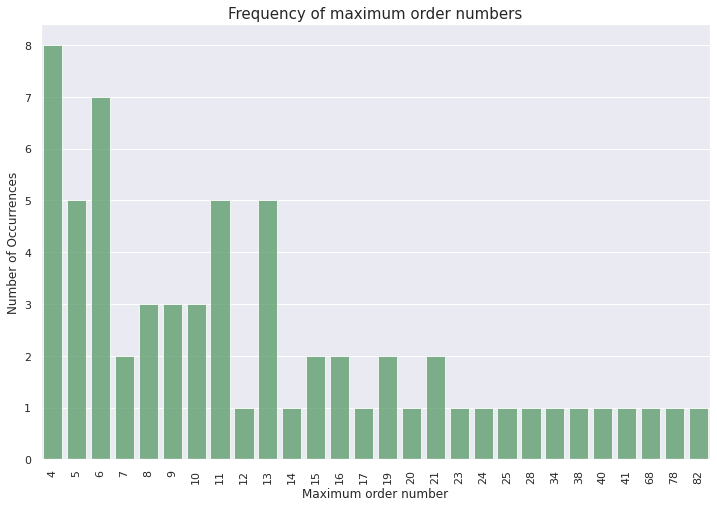

In [14]:
%%fsql
tempdf = SELECT user_id, MAX(order_number) AS n_orders FROM orders
         GROUP BY user_id
         PRINT 2 ROWS

SELECT n_orders, COUNT(n_orders) AS count FROM tempdf
GROUP BY n_orders
OUTPUT USING max_order_barplot

## Ran out of memory?  Slow code?  No problem!

`FugueSQL` runs on `pandas` by default which loads the data into memory and uses only a single core!

`FugueSQL` can optionally run on `spark` or `dask` instead and use `memory spillover` to handle bigger-than-memory data and as many cores as your machine has! 

In [15]:
%%fsql
LOAD "s3://kaggle-data-instacart/products.csv" (header=TRUE, infer_schema=TRUE)
YIELD DATAFRAME AS products

In [17]:
%%fsql
LOAD "s3://kaggle-data-instacart/order_products__prior.csv" (header=TRUE, infer_schema=TRUE, nrows=1000)
YIELD DATAFRAME AS order_products

In [18]:
%%fsql
LOAD "s3://kaggle-data-instacart/departments.csv" (header=TRUE, infer_schema=TRUE)
YIELD DATAFRAME AS departments

This operation would run out of memory on `pandas` but not on `dask`!

Just replace  `%%fsql` with `%%fsql dask`

In [21]:
%%fsql dask
SELECT order_id, aisle, product_name, department, reordered FROM order_products
INNER JOIN products ON order_products.product_id = products.product_id
INNER JOIN aisles ON products.aisle_id = aisles.aisle_id
INNER JOIN departments ON departments.department_id = products.department_id
SAVE OVERWRITE "/tmp/working/result.parquet"